
## $ \textbf{Burgers equation}$ 

### $\frac{\partial{u}}{{\partial{t}}} + u\frac{\partial{u}}{\partial{x}} = v\frac{\partial{u}^2}{\partial{x}^2}$

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

# Defining the Neural Network

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

# IC, BC, Optimizer

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # computation domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        ## Train data
        
        # Boundary Conditions
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        
        # Initial Conditions
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:,0])
        
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        #---- Optimizer setting-----#
        self.adam = torch.optim.Adam(self.model.parameters())
        
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr = 1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = "strong_wolfe"
        )
        
    #----------- Loss Function ------------#
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u, 
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        
        du_dXX = torch.autograd.grad(
            du_dX, 
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, (0.01/math.pi) * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        
        return loss

    # ---------- Training Function -------------#
    def train(self):
        self.model.train()
        for i in range (1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()
               

In [4]:
# Training
net = Net()
net.train()

C:\Users\dimka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.19195929169654846
200 0.09819023311138153
300 0.08414207398891449
400 0.06696316599845886
500 0.05451463162899017
600 0.03741489350795746
700 0.02748192846775055
800 0.021309204399585724
900 0.01640625298023224
1000 0.01297669392079115
1100 0.004274805076420307
1200 0.0023477051872760057
1300 0.0012048594653606415
1400 0.0006278898217715323
1500 0.0004112590686418116
1600 0.0003018628340214491
1700 0.00033713283482939005
1800 0.00021335083874873817
1900 0.00018559867748990655
2000 0.00017163441225420684
2100 0.00016169046284630895
2200 0.000157922477228567
2300 0.00013700974523089826
2400 0.0001243117731064558
2500 0.00011191969679202884
2600 0.00010289317287970334
2700 9.275117190554738e-05
2800 8.550315396860242e-05
2900 8.052728662732989e-05
3000 7.510192517656833e-05
3100 7.179967360571027e-05
3200 6.822829891461879e-05
3300 6.501666211988777e-05
3400 6.237556226551533e-05
3500 5.988171687931754e-05
3600 5.651990068145096e-05
3700 5.405696720117703e-05
3800 5.0992093747481704

# Evaluation & Results

## Heatmap

In [5]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [6]:
h = 0.01
k = 0.01

x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [7]:
X.shape

torch.Size([20000, 2])

In [8]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

In [9]:
y_pred.shape

(200, 100)

In [10]:
y_pred

array([[ 0.00233838,  0.00192404,  0.00158909, ..., -0.00155237,
        -0.0015431 , -0.00153241],
       [ 0.03406224,  0.0326646 ,  0.03140098, ...,  0.00607136,
         0.00602162,  0.0059751 ],
       [ 0.0656507 ,  0.06328678,  0.06110862, ...,  0.01370528,
         0.01359701,  0.01349229],
       ...,
       [-0.09574088, -0.09296849, -0.09035711, ..., -0.02511343,
        -0.02489239, -0.0246717 ],
       [-0.06337252, -0.06158599, -0.05990671, ..., -0.01717141,
        -0.01701063, -0.01685038],
       [-0.03066874, -0.02989477, -0.02917203, ..., -0.00922221,
        -0.00912252, -0.00902164]], shape=(200, 100), dtype=float32)

In [12]:
sns.set_style("white")
plt.figure(figsize = (5,3), dpi = 3000)
sns.heatmap(y_pred, cmap = 'jet')

<Axes: >

## Initial vs Final Solution

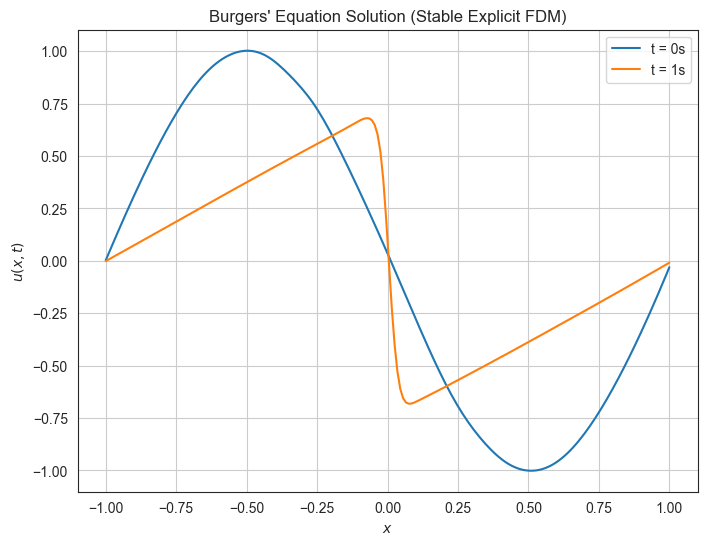

In [21]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(-1,1, len(y_pred[:,0])),y_pred[:,0], label="t = 0s")
plt.plot(np.linspace(-1,1, len(y_pred[:,-1])),y_pred[:,-1], label=f"t = 1s")
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x,t)$")
plt.title("Burgers' Equation Solution (Stable Explicit FDM)")
plt.grid(True)
plt.legend()
plt.show()

## Solution Over Time

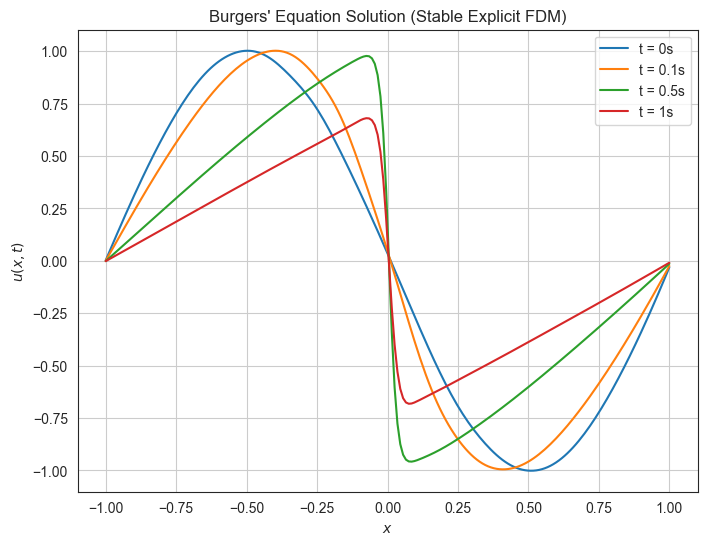

In [ ]:
# ---------------------------
# Ploting solution over time
# ---------------------------
plt.figure(figsize=(8,6))
plt.plot(np.linspace(-1,1, len(y_pred[:,0])),y_pred[:,0], label="t = 0s")
plt.plot(np.linspace(-1,1, len(y_pred[:,10])),y_pred[:,10], label="t = 0.1s")
plt.plot(np.linspace(-1,1, len(y_pred[:,50])),y_pred[:,50], label="t = 0.5s")
plt.plot(np.linspace(-1,1, len(y_pred[:,-1])),y_pred[:,-1], label=f"t = 1s")
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x,t)$")
plt.title("Burgers' Equation Solution (Stable Explicit FDM)")
plt.grid(True)
plt.legend()
plt.show()